# Data analysis

## 0. Setup

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from pathlib import Path
import sys

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

## 1. EDA of SNAP & HIU

### 1.1. HIU EDA

### 1.2. SNAP EDA

## 2. Exhaustiveness analysis of referrals

In [27]:
from src.analysis_helpers import (
    load_and_merge_structured_and_predictions,
    create_exhaustiveness_long_format
)

def summarize_exhaustiveness(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize documentation status counts and compute recall per SDoH.

    Parameters:
    - df_long: Long-format exhaustiveness DataFrame.

    Returns:
    - Summary DataFrame with counts and recall score.
    """
    summary = df_long.groupby(["sdoh_category", "documentation_status"]).size().unstack(fill_value=0)
    summary["Recall (Exhaustiveness)"] = (
        summary["Documented & Experienced"] /
        (summary["Documented & Experienced"] + summary["Undocumented but Experienced"])
    ).round(2)
    return summary

In [ ]:
hiu_structured_path =  "../data/processed/brc-cleaned/hiu_final.csv"
hiu_predictions_path = "../results/inference/hiu_final__Llama-3.1-8B-Instruct_bs8_lr9e-05_epochs6_20250710_164937_predictions/predictions.csv"

hiu_mapping = {
    "housing_need": "housing",
    "finances_need": "finances",
    "loneliness_need": "loneliness"
}

df_hiu = load_and_merge_structured_and_predictions(
    structured_path=hiu_structured_path,
    predictions_path=hiu_predictions_path
)

df_hiu_long = create_exhaustiveness_long_format(
    df_merged=df_hiu,
    structured_to_label=hiu_mapping
)

df_hiu_summary = summarize_exhaustiveness(df_hiu_long)

print("=== HIU Dataset: SDoH Exhaustiveness Summary ===")
display(df_hiu_summary)

=== HIU Dataset: SDoH Exhaustiveness Summary ===


documentation_status,Documented & Experienced,Documented but Not Experienced,Neither Documented Nor Experienced,Undocumented but Experienced,Recall (Exhaustiveness)
sdoh_category,,,,,
finances,56,70,713,249,0.18
housing,122,69,650,247,0.33
loneliness,243,70,194,581,0.29


In [20]:
snap_structured_path = "../data/processed/brc-cleaned/snap_final.csv"
snap_predictions_path = "../results/inference/snap_final__Llama-3.1-8B-Instruct_bs8_lr9e-05_epochs6_20250710_164937_predictions/predictions.csv"

snap_mapping = {
    "housing_need": "housing",
    "loneliness_need": "loneliness",
    "finances_need": "finances",
    "food_insecurity_need": "foodaccess"
}

df_snap = load_and_merge_structured_and_predictions(
    structured_path=snap_structured_path,
    predictions_path=snap_predictions_path
)

df_snap_long = create_exhaustiveness_long_format(
    df_merged=df_snap,
    structured_to_label=snap_mapping
)

df_snap_summary = summarize_exhaustiveness(df_snap_long)

print("=== SNAP Dataset: SDoH Exhaustiveness Summary ===")
display(df_snap_summary)

=== SNAP Dataset: SDoH Exhaustiveness Summary ===


documentation_status,Documented & Experienced,Documented but Not Experienced,Neither Documented Nor Experienced,Undocumented but Experienced,Recall (Exhaustiveness)
sdoh_category,,,,,
finances,43,34,484,148,0.23
foodaccess,92,144,401,72,0.56
housing,54,73,458,124,0.30
loneliness,165,90,295,159,0.51


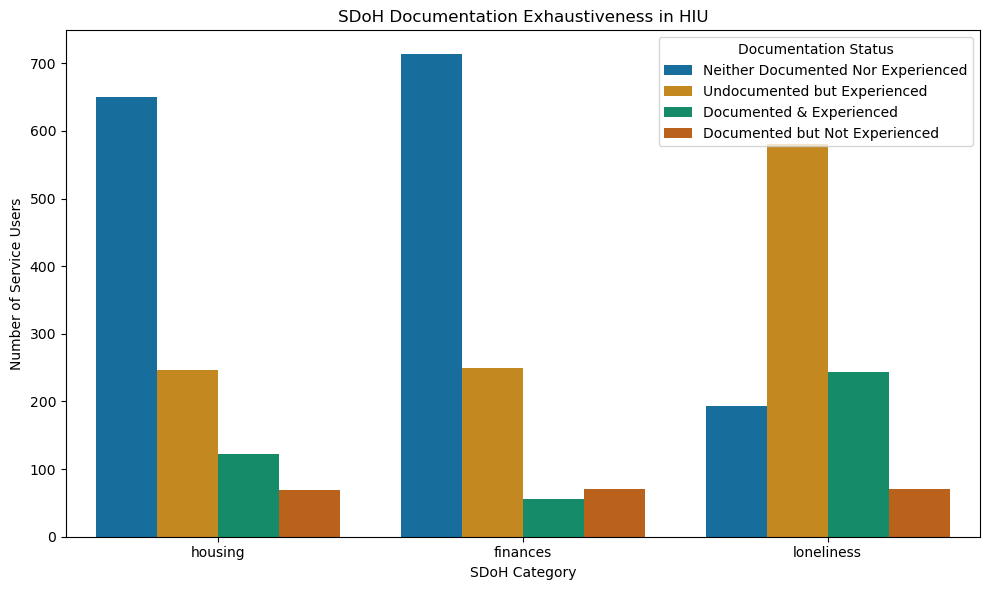

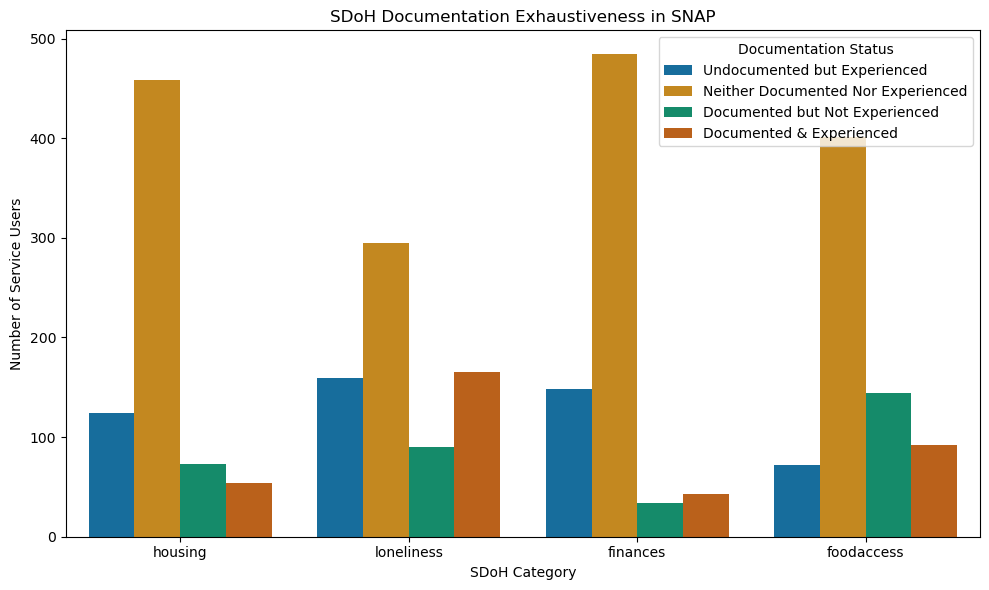

In [28]:
def plot_exhaustiveness_bar(df_long, dataset_name="Dataset"):
    """
    Plot a stacked bar chart showing SDoH documentation exhaustiveness.

    Parameters:
    - df_long: Long-format DataFrame from create_exhaustiveness_long_format
    - dataset_name: Name of the dataset for plot title
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=df_long,
        x="sdoh_category",
        hue="documentation_status",
        palette="colorblind"
    )
    plt.title(f"SDoH Documentation Exhaustiveness in {dataset_name}")
    plt.ylabel("Number of Service Users")
    plt.xlabel("SDoH Category")
    plt.legend(title="Documentation Status", loc="upper right")
    plt.tight_layout()
    plt.show()

plot_exhaustiveness_bar(df_hiu_long, dataset_name="HIU")
plot_exhaustiveness_bar(df_snap_long, dataset_name="SNAP")

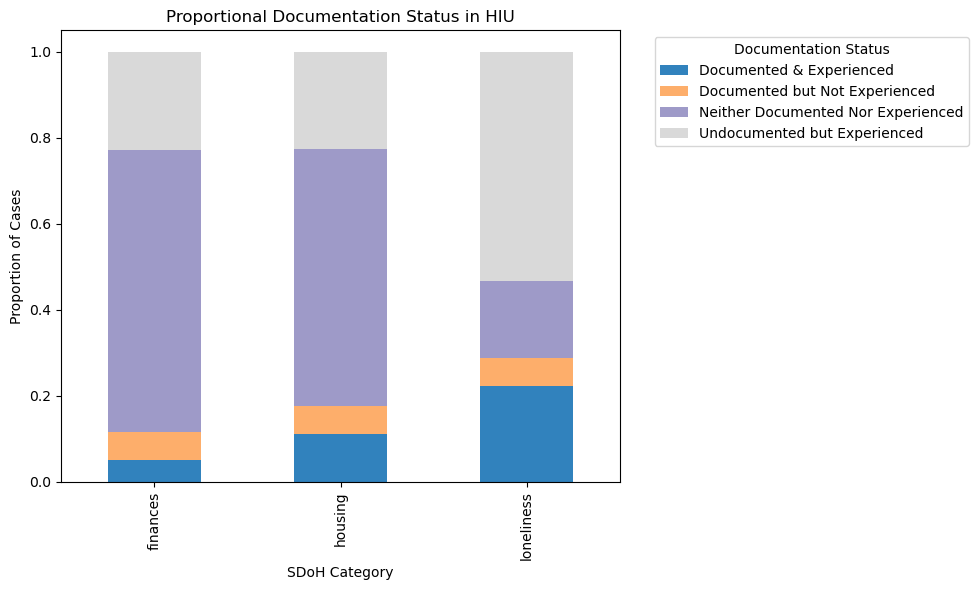

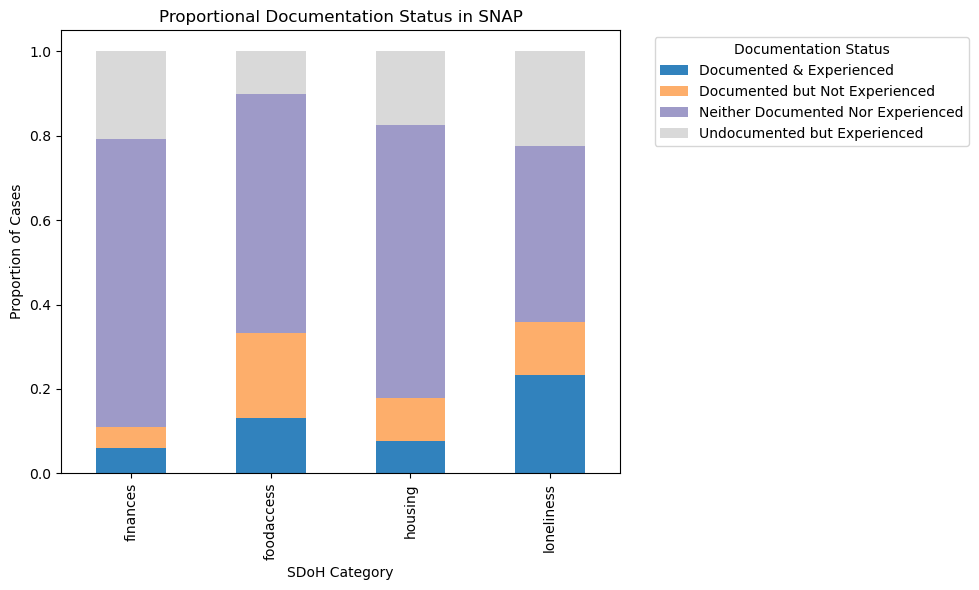

In [29]:
def plot_exhaustiveness_stacked_percentage(df_long, dataset_name="Dataset"):
    data = df_long.groupby(["sdoh_category", "documentation_status"]).size().unstack(fill_value=0)
    data_pct = data.div(data.sum(axis=1), axis=0)

    data_pct.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20c")
    plt.title(f"Proportional Documentation Status in {dataset_name}")
    plt.ylabel("Proportion of Cases")
    plt.xlabel("SDoH Category")
    plt.legend(title="Documentation Status", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_exhaustiveness_stacked_percentage(df_hiu_long, dataset_name="HIU")
plot_exhaustiveness_stacked_percentage(df_snap_long, dataset_name="SNAP")

<Axes: xlabel='sdoh_category', ylabel='Recall (Exhaustiveness)'>

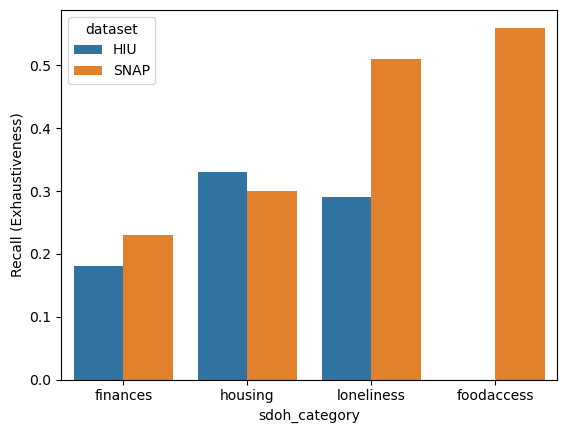

In [25]:
df_hiu_summary["dataset"] = "HIU"
df_snap_summary["dataset"] = "SNAP"
df_combined = pd.concat([df_hiu_summary, df_snap_summary])
df_combined_reset = df_combined.reset_index()[["sdoh_category", "Recall (Exhaustiveness)", "dataset"]]

sns.barplot(data=df_combined_reset, x="sdoh_category", y="Recall (Exhaustiveness)", hue="dataset")